In [10]:
# import the wrapper
from Leaf import *

In [11]:
# The wrapper can be either initialized by a parameter file (legacy) 
# or given the parameters directly as dict (recommended).
# Parameters not given are automatically set to default

# An initialization of the wrapper may look like this (remove anything not needed)
# The given values repres

# set a path where the data will be saved
data_path = "./data/" # <- don't forget the "/" at the end
# set a prefix for the saved files
data_prefix = "run_" # results in files run_{run_id}.h5
# set a path for the cache, if None, write no cache (recommended for sampling)
cache_path = None


Leaf

Init signature:
Leaf(
    data_path: str = './data/',
    data_prefix: str = 'simrun_',
    parameter_file: str = None,
    cache_path: str = None,
    debug: bool = False,
    astro_params: dict = {},
    cosmo_params: dict = {},
    user_params: dict = {},
    flag_options={},
    global_params: dict = {},
) -> None
Docstring:      <no docstring>
Init docstring:
Initializes the Leaf class with specified parameters.

Args:
    data_path (str): The path where output will be saved. Default is "./data/"

    data_prefix (str): The prefix for the output files saved in the specified data_path. Default is "simrun_".
    
    parameter_file (str): The file from which to load parameters for all runs. This allows for more control over specific parameters.
                          If None, standard parameters are used. Default is None.
    
    cache_path (str): Path for the 21cmFAST cache. If None, don't write cache. This can be faster if fast IO is available, but requires significant memory 

In [3]:
# To just run a single box using the parameters one can just 
sim.run_box()

In [8]:
# To simulate a lightcone, one can do
sim.run_cone()
# Now we clear the cached simulations for the next step
#sim.clear()

In [ ]:
# All parameters can be changed on the fly without re-initializing the class, e.g.
params = {"redshift": 8, "max_redshift": 12, "random_seed": 1, "astro_params": {"HII_EFF_FACTOR": 29}} 
# Note: It is important to preserve the dict structure defined in parameter.yaml for in-situ changes in parameters
# This dict needs to be passed as an argument to the wrapper
sim.run_lightcone(kargs=params)

In [ ]:
# One can also do multiple runs with different parameters, e.g. we want two realizations of two HII_EFF_FACTORs
params = {"random_seed": [1,2], "astro_params": {"HII_EFF_FACTOR": [29,31]}}
sim.run_fixed_multi_lightcone(rargs=params)
# The result will be four simulations stored in the class

In [ ]:
# One can sample from a distribution (callable function) given by samplef and a dict of ranges
# This is useful to create a database
# For cluster deployment, change the threads argument to the number of available cpu cores
samplef = (lambda a,b: np.random.uniform(a,b))
args = {"astro_params": 
            {"NU_X_THRESH": [400,700], 
            "HII_EFF_FACTOR": [20,40],
            "L_X": [30,50],
            "ION_Tvir_MIN": [4,5]},
        "cosmo_params":
            {"OMm": [0.1,0.3]},
        "global_params": 
            {"M_WDM": [1,3]}}
sim.run_samplef(nruns=12, args=args, samplef=samplef, threads = 6)

In [ ]:
# Now we visualize the result
# Visualize the power spectrum computed in 6 bins
sim.plot_ps(bins=6,compare=True)
# Plot the global quantities of the simulations
sim.plot_global_properties(observational_axis=True)
# Plot various fields of the simulation
sim.plot_imshow(fields=["brightness_temp","xH_box", "density"])


In [ ]:
# If a function is unclear, one can always look at the docstring for help
sim.plot_ps?

In [ ]:
np.array([1,23,np.NaN]).max()

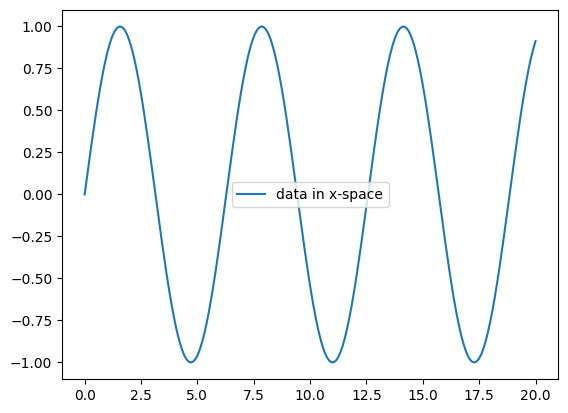

In [63]:
x = np.linspace(0,20, 200)
fx = np.sin(x)

plt.plot(x,fx, label = "data in x-space")

plt.legend()
plt.show()

In [55]:
fft_fk

array([0.03170549, 0.03900246, 0.07227378, 0.4620918 , 0.12221749,
       0.05735107, 0.03856072, 0.02948949, 0.02408319, 0.02046243,
       0.01785138, 0.0158702 , 0.01431023, 0.01304695, 0.01200117,
       0.01111999, 0.01036665, 0.00971473, 0.00914476, 0.00864201,
       0.00819514, 0.00779526, 0.00743532, 0.00710961, 0.00681347,
       0.00654309, 0.00629526, 0.00606732, 0.00585701, 0.00566238,
       0.0054818 , 0.00531383, 0.00515725, 0.00501096, 0.00487404,
       0.00474564, 0.00462503, 0.00451157, 0.00440468, 0.00430383,
       0.00420857, 0.00411848, 0.00403319, 0.00395236, 0.00387567,
       0.00380286, 0.00373368, 0.00366788, 0.00360526, 0.00354562,
       0.0034888 , 0.00343462, 0.00338294, 0.00333363, 0.00328654,
       0.00324157, 0.00319861, 0.00315755, 0.0031183 , 0.00308079,
       0.00304491, 0.00301061, 0.00297781, 0.00294644, 0.00291645,
       0.00288778, 0.00286037, 0.00283418, 0.00280916, 0.00278526,
       0.00276245, 0.00274069, 0.00271994, 0.00270017, 0.00268

In [54]:
fft_k[3]

0.6000000000000001

In [1]:
from powerbox import get_power
import numpy as np
from matplotlib import pyplot as plt
import py21cmfast as p21c

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [54]:
lc = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
# choose the right boundaries such that it maches the redshift interval
bottom, top = 1000, 1050
print(lc.lightcone_redshifts[bottom:top])
print(lc.cell_size)

[11.98940139 12.00014537 12.01090256 12.02167321 12.03245727 12.04325474
 12.05406563 12.06488989 12.07572764 12.08657897 12.09744379 12.10832204
 12.11921401 12.13011949 12.14103858 12.15197126 12.16291762 12.17387763
 12.18485137 12.19583878 12.20683997 12.21785497 12.22888368 12.23992625
 12.25098261 12.26205297 12.27313705 12.28423506 12.29534701 12.30647301
 12.31761286 12.32876677 12.33993462 12.35111664 12.36231268 12.3735228
 12.38474699 12.39598539 12.4072379  12.4185046  12.42978551 12.44108075
 12.4523902  12.46371395 12.47505189 12.48640423 12.49777101 12.50915198
 12.52054754 12.53195735]
1.8181818181818181


In [65]:
def ps2d(data, size, **kwargs):
    #size = data.shape
    ps_perp,k_perp, _ = get_power(data, boxlength=size, res_ndim=2,
                                  ignore_zero_mode=True, bin_ave=True, **kwargs) 
    #ps_par, k_par, _ = get_power(data.T, boxlength=size, res_ndim=1,  
    #                             ignore_zero_mode=True, bin_ave=True, **kwargs)
    #ps_perp = np.mean(ps_perp,axis=1)
    #ps_par = np.mean(ps_par, axis=(1,2))
    v = np.prod(size)
    #ps = np.outer(ps_par*k_par, ps_perp*k_perp**2)
    return k_perp, ps_perp

In [66]:
k_perp, ps = ps2d(lc.brightness_temp[:,:,bottom:top],
                         lc.cell_size*np.array([*lc.brightness_temp.shape[:2], top-bottom]), bins=15)

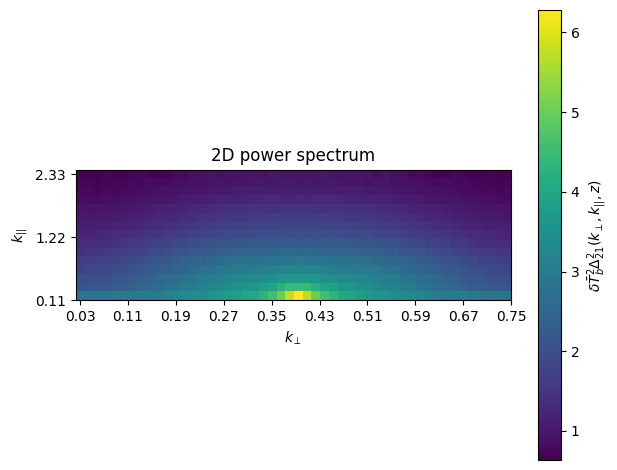

In [67]:
fig, ax = plt.subplots()
ax_img = ax.imshow(np.log10(ps[::-1,:]))
dim_y, dim_x = ps.shape
num_y, num_x = (dim_y // 5, dim_x // 5)
ax.set_yticks(np.linspace(0,dim_y-0.5,num_y), np.round(np.linspace(k_perp.min(), k_perp.max(), num_y)[::-1], 2))
ax.set_xticks(np.linspace(0, dim_x-0.5, num_x),  np.round(np.linspace(k_par.min(), k_par.max(), num_x),2))
ax.set_xlabel(r"$k_\perp$")
ax.set_ylabel(r"$k_{||}$")
ax.set_title("2D power spectrum")
plt.colorbar(ax_img, ax=ax, label=r"$\delta \bar{T}_b^2 \Delta^2_{21}(k_\perp, k_{||}, z)$")

fig.tight_layout()
fig.savefig("./ps.jpg", dpi=300)

In [69]:
print(ps.shape)

(15, 50)


In [5]:
for i in generate_ids(quantity, threads):
    print(i)

NameError: name 'generate_ids' is not defined

In [1]:
from Leaf import *

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [1]:
import py21cmfast as p21c

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
up = p21c.inputs.UserParams()
print(up)
up.update(**{})
print(up)

UserParams:
    BOX_LEN                 : 300.0
    DIM                     : 600
    FAST_FCOLL_TABLES       : False
    HII_DIM                 : 200
    HMF                     : 1
    KEEP_3D_VELOCITIES      : False
    MINIMIZE_MEMORY         : False
    NON_CUBIC_FACTOR        : 1.0
    NO_RNG                  : False
    N_THREADS               : 1
    PERTURB_ON_HIGH_RES     : False
    POWER_SPECTRUM          : 0
    USE_2LPT                : True
    USE_FFTW_WISDOM         : False
    USE_INTERPOLATION_TABLES: True
    USE_RELATIVE_VELOCITIES : False
    
UserParams:
    BOX_LEN                 : 300.0
    DIM                     : 600
    FAST_FCOLL_TABLES       : False
    HII_DIM                 : 200
    HMF                     : 1
    KEEP_3D_VELOCITIES      : False
    MINIMIZE_MEMORY         : False
    NON_CUBIC_FACTOR        : 1.0
    NO_RNG                  : False
    N_THREADS               : 1
    PERTURB_ON_HIGH_RES     : False
    POWER_SPECTRUM          : 0
 

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [3]:
un_lcsampling(self, samplef: Callable, redshift: float, save: bool = True, random_seed: int = None, 
                sanity_check: bool = True, make_statistics: bool = True, filter: bool = True,
                override: bool = False, threads: int = 1, mpi: bool = False, quantity: int = 1,
                astro_params_range: dict = None, cosmo_params_range: dict = None, user_params_range: dict = None,
                flag_options_range = None, global_params_range: dict = None)



SyntaxError: invalid syntax (2213924696.py, line 1)

In [2]:
from Leaf import *
user_parameter = {
    "HII_DIM": 30,
    "BOX_LEN": 150,
}
flag_options = {
    "INHOMO_RECO": True,
    "USE_TS_FLUCT": True
}

sim = Leaf(user_params=user_parameter, flag_options=flag_options, debug=True)

astro_params_range = {
    "L_X": [39.42, 39.84],
    "HII_EFF_FACTOR": [29,29.5]

}


testsim = sim.run_lightcone(save=False, redshift=5., filter_peculiar=False)


#if __name__ == '__main__':
#    sim.run_lcsampling(samplef=sim.uniform, redshift=5.5, save=True, threads=2, quantity=4,
#                    astro_params_range=astro_params_range)

Set initial parameters...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30.0
    ION_Tvir_MIN    : 49999.9995007974
    L_X             : 1e+40
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500.0
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 49999.9995007974
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
    POWER_INDEX: 0.9665
    SIGMA_8    : 0.8102
    hlittle    : 0.6766
    
user_params

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


Done simulating. Do sanity check...
Sanity check passed. Write statistics...
Statistics written. Do filtering...
Filtering passed. Save or return file now.


In [1]:
from Leaf import *
cosmo_params = {
"OMm": 0.2
}
astro_params = {
"L_X": 40,
"NU_X_THRESH": 100,
"ION_Tvir_MIN": 4.5,
"HII_EFF_FACTOR": 29,
"INHOMO_RECO": True
}
global_params = {
    "M_WDM": 4
}
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

sim = Leaf(debug=True)



testsim = sim.run_lightcone(save=False, redshift=5., filter_peculiar=False,
                            cosmo_params=cosmo_params, astro_params=astro_params,
                            global_params=global_params, user_params=user_params,
                            flag_options=flag_options)


#if __name__ == '__main__':
#    sim.run_lcsampling(samplef=sim.uniform, redshift=5.5, save=True, threads=2, quantity=4,
#                    astro_params_range=astro_params_range)

Set initial parameters...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 29
    ION_Tvir_MIN    : 31622.776601683792
    L_X             : 10000000000000000000000000000000000000000
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 100
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 50.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 31622.776601683792
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.2
    POWER_INDEX: 0.9665
    SIGMA_8    : 0.8102
    hlittle    : 0.6

2024-07-09 19:20:46 | DEBUG   | GenerateICs.c   | ComputeInitialConditions:205 [pid=7390/thr=0] | Finished initialization.
2024-07-09 19:20:46 | DEBUG   | ps.c            | TFset_parameters:481 [pid=7390/thr=0] | Setting Transfer Function parameters.
2024-07-09 19:20:46 | DEBUG   | ps.c            | init_ps:636 [pid=7390/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-07-09 19:20:46 | DEBUG   | ps.c            | init_ps:656 [pid=7390/thr=0] | Initialized Power Spectrum.
2024-07-09 19:20:46 | DEBUG   | GenerateICs.c   | ComputeInitialConditions:255 [pid=7390/thr=0] | Drawn random fields.
2024-07-09 19:20:46 | DEBUG   | GenerateICs.c   | ComputeInitialConditions:265 [pid=7390/thr=0] | FFT'd hires boxes.
2024-07-09 19:20:46 | DEBUG   | GenerateICs.c   | ComputeInitialConditions:401 [pid=7390/thr=0] | Completed Relative velocities.
2024-07-09 19:20:46 | DEBUG   | GenerateICs.c   | ComputeInitialCondi

KeyboardInterrupt: 

In [6]:
if not int(3):
    print('hi')

In [38]:
dict1 = {
    'a': 1.5,
    'b': {
        'b1': 2,
        'b2': 3.5
    },
    'c': 4
}

dict2 = {
    'a': [1.0, 2.0],
    'b': {
        'b1': [2.0, 3.0],
        'b2': [3.0, 4.0]
    },
    'c': [4.0, 5.0],
    'd': [0.0, 1.0]  # extra key not in dict1
}
replace_values(dict2,[1,2,3,4,5])

{'a': 1, 'b': {'b1': 2, 'b2': 3}, 'c': 4, 'd': 5}

In [35]:
dict1

{'a': 1.5, 'b': {'b1': 2, 'b2': 3.5}, 'c': 4}

In [1]:
def test(blub, **lc_params):
    return

In [4]:
t = test("hi")

hi


In [5]:
t is None

True

In [ ]:
from Leaf import *
